In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from imblearn.over_sampling import SMOTENC

In [2]:
df = pd.read_excel('/home/sam/tirocinio/DB PAROTIDE DEF_corretto.xlsx', sheet_name='Sheet7')
df = df.loc[df['ESCLUDERE'] == 0]
df.reset_index(inplace = True)
df = df.loc[df['COD ISTO'] != 6]
df = df.loc[df['COD ISTO'] != 2]
df = df.loc[df['COD ISTO'] != 4]
df.reset_index(inplace = True)
df = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2','COD ISTO']]
df['ADC'] = df['ADC'].apply(lambda s: str(s).replace(',', '.')).astype(float)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Segni macro malignità  71 non-null     int64  
 1   ADC                    71 non-null     float64
 2   TIC type               71 non-null     object 
 3   T2                     71 non-null     int64  
 4   COD ISTO               71 non-null     int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 2.9+ KB


In [4]:
y = df['COD ISTO'].copy()
X_not_encoded = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2']].copy()
X = pd.get_dummies(X_not_encoded, columns = ['TIC type'])

In [5]:
y.value_counts()

3    53
1    12
5     6
Name: COD ISTO, dtype: int64

In [6]:
def esperimento(X,y, tuned_parameters = {'criterion':['entropy'],'max_depth': list(range(2,7)),
                'min_samples_leaf': [2],'class_weight':['balanced']},
               test_size = 0.25, scoring_f = accuracy_score, cv= 3, random_state_tree = None,
                n_it = 10, smotenc_aug = False, print_best_tree = False):
    trees = []
    scores = []
    
    for n_it in range(1,11):
        print('### ITERATION %d ###\n\n' %(n_it))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                            shuffle = True, stratify = y)
        if smotenc_aug == True:

            smt = SMOTENC(k_neighbors = 3, random_state=None, categorical_features=[0,2,3,4],
                          sampling_strategy = 'minority')

            for i in range(2):

                X_train, y_train = smt.fit_resample(X_train, y_train)
            
        if scoring_f is f1_score:
                
            scorer = make_scorer(f1_score, average = 'weighted')
        else:
            scorer = make_scorer(scoring_f)
            
        clf = tree.DecisionTreeClassifier(random_state = random_state_tree)
        
        clf_gs = GridSearchCV(clf, tuned_parameters, scoring = scorer, cv = cv, refit = True)
        clf_gs.fit(X_train, y_train)
        params = clf_gs.best_params_
        score_ = clf_gs.best_score_
        best_clf = clf_gs.best_estimator_
        score_test_set = scorer(best_clf, X_test, y_test)
        trees.append(best_clf)
        scores.append(score_test_set)
        print("Parameters set found:\n")
        print(params)
        print()
        print('Scoring function used: ')
        print(scorer)
        print("Cross-validated score of the estimator on training set: %0.3f\n" %( score_))
        print('Score on test set: %0.3f\n' %(score_test_set))
        print('Classification report on test set: \n')
        print(classification_report(y_test, best_clf.predict(X_test), zero_division = 0))
        
    print('\n\n### Mean final score: %0.3f , Std dev: %0.3f ###' %( np.mean(scores), np.std(scores)))
    
    if print_best_tree :
        print('\n\n### Best tree based on selected scoring function: ###')
        best_iteration = np.argmax(scores)
        print('Referred iteration: {}'.format(best_iteration+1))
        best_tree = trees[best_iteration]
        
        fig, ax = plt.subplots()
        fig.set_size_inches(17, 12)
        
        print(best_tree.get_params())
        tree.plot_tree(best_tree, feature_names = X.columns,
               class_names = ['1', '3', '5'], filled = True, rounded = True, ax = ax)
            

In [7]:
seed = 42

### ITERATION 1 ###


Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator on training set: 0.908

Score on test set: 0.889

Classification report on test set: 

              precision    recall  f1-score   support

           1       1.00      0.67      0.80         3
           3       0.92      0.92      0.92        13
           5       0.67      1.00      0.80         2

    accuracy                           0.89        18
   macro avg       0.86      0.86      0.84        18
weighted avg       0.91      0.89      0.89        18

### ITERATION 2 ###


Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator on training set: 0.900

Score on test set: 0.833

Classification report on

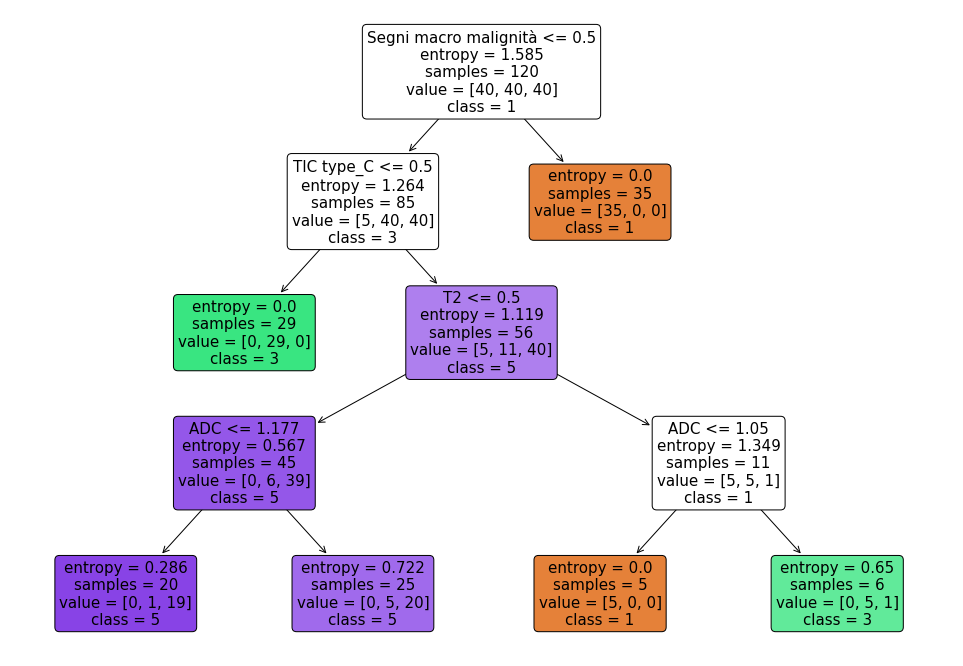

In [8]:
#alberi bilanciati, accuratezza, sì smotenc, sì print
esperimento(X, y, smotenc_aug = True, print_best_tree = True, random_state_tree = seed )

### ITERATION 1 ###


Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator on training set: 0.878

Score on test set: 0.918

Classification report on test set: 

              precision    recall  f1-score   support

           1       1.00      0.75      0.86         4
           3       0.94      0.94      0.94        18
           5       0.67      1.00      0.80         2

    accuracy                           0.92        24
   macro avg       0.87      0.90      0.87        24
weighted avg       0.93      0.92      0.92        24

### ITERATION 2 ###


Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator on training set: 0.904

Score on test set: 0.778



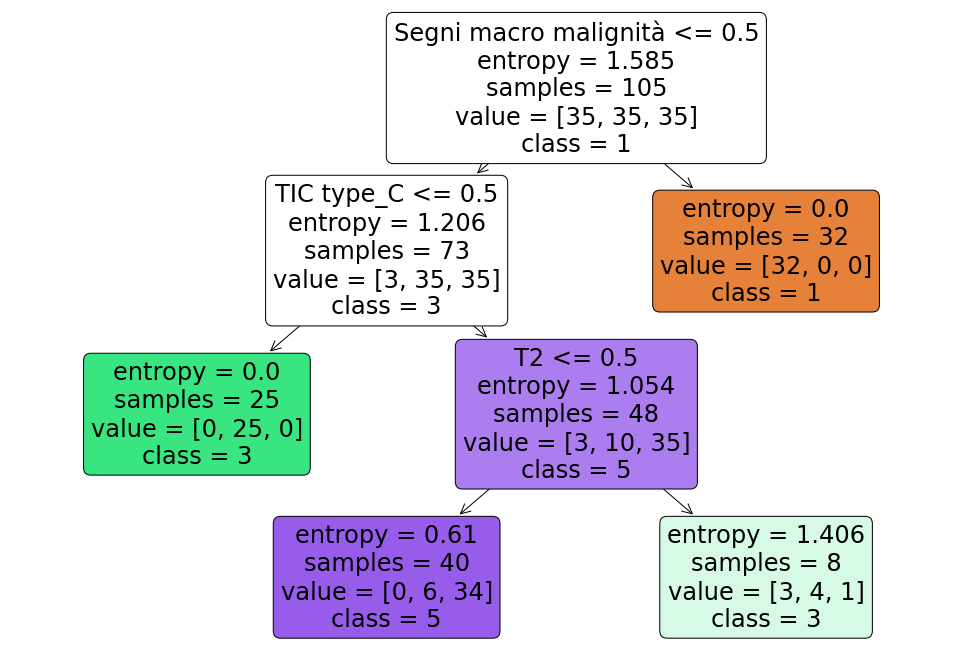

In [9]:
#bilanciati, ma con f1_score
#provo a diminuire il numero di fold, ora il dataset è molto piccolo quindi potrebbe aver senso
#sempre alberi bilanciati, sempre accuratezza, sempre smotenc
esperimento(X, y, smotenc_aug = True, print_best_tree = True,
            random_state_tree = seed, test_size = 0.33, cv = 2,
           scoring_f = f1_score)

### ITERATION 1 ###


Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator on training set: 0.922

Score on test set: 0.852

Classification report on test set: 

              precision    recall  f1-score   support

           1       0.80      1.00      0.89         4
           3       1.00      0.78      0.88        18
           5       0.40      1.00      0.57         2

    accuracy                           0.83        24
   macro avg       0.73      0.93      0.78        24
weighted avg       0.92      0.83      0.85        24

### ITERATION 2 ###


Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator on training set: 0.905

Score on test set: 0.801



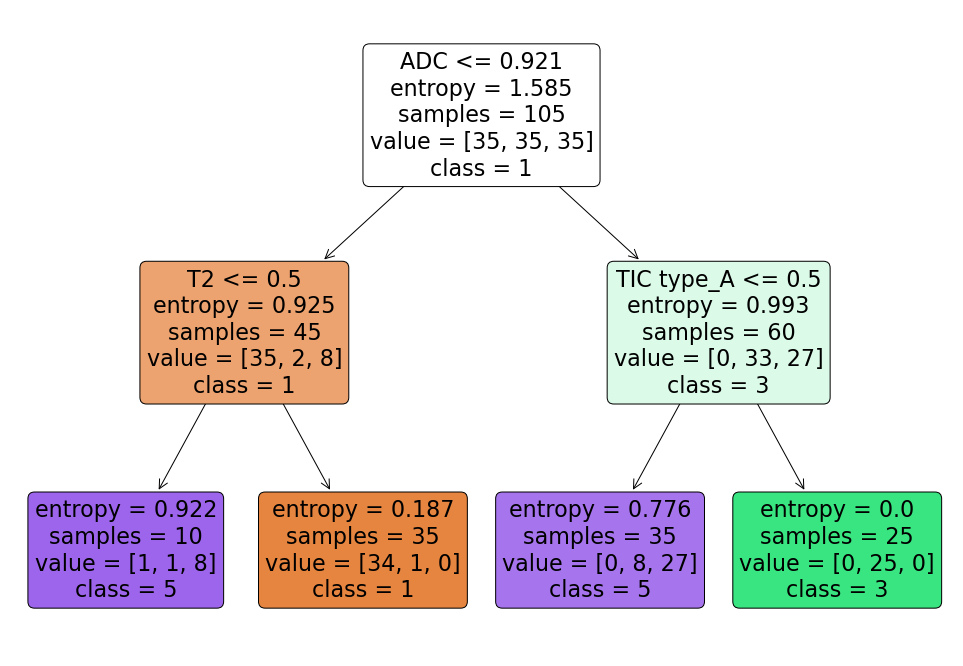

In [10]:
esperimento(X, y, smotenc_aug = True, print_best_tree = True,
            random_state_tree = seed, test_size = 0.33, cv = 2,
           scoring_f = f1_score)

### ITERATION 1 ###


Parameters set found:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator on training set: 0.925

Score on test set: 0.611

Classification report on test set: 

              precision    recall  f1-score   support

           1       1.00      0.50      0.67         4
           3       0.83      0.56      0.67        18
           5       0.00      0.00      0.00         2

    accuracy                           0.50        24
   macro avg       0.61      0.35      0.44        24
weighted avg       0.79      0.50      0.61        24

### ITERATION 2 ###


Parameters set found:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator on training set: 0.914

Score on test set: 0.886

Classificati

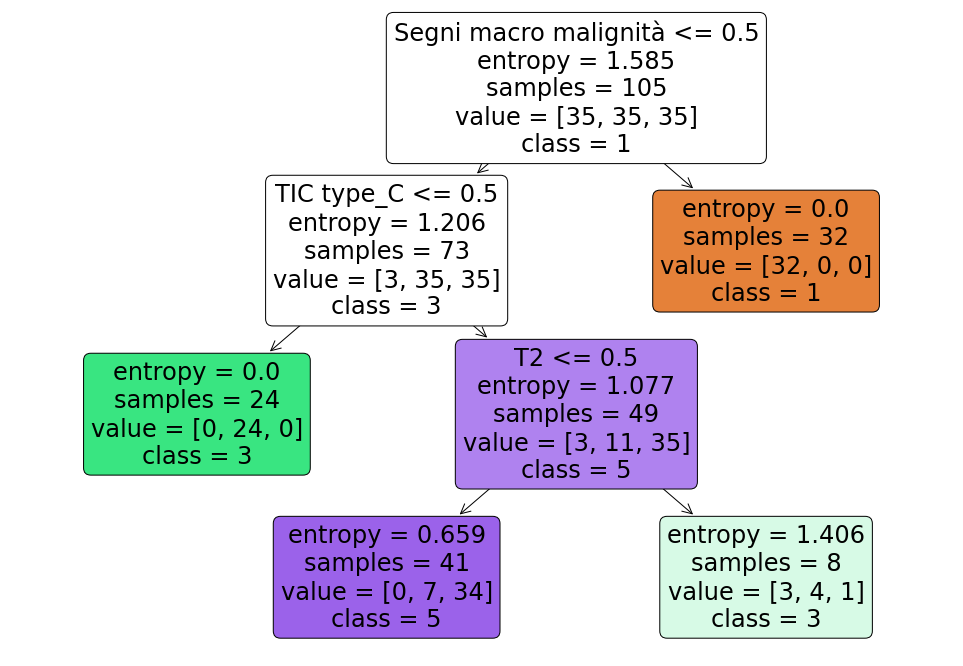

In [11]:
#non bilanciati
esperimento(X, y, smotenc_aug = True, print_best_tree = True,
            random_state_tree = seed, test_size = 0.33, cv = 2,
           scoring_f = f1_score, tuned_parameters = {'criterion':['entropy'],
                                                     'max_depth': list(range(2,7)),
                'min_samples_leaf': [2],'class_weight':[None]} )

In [12]:
#implmento il mio algoritmo sulla base delle regole usate dall'albero che classifica 1,3,5

def my_algoritmo(x):
    if x['Segni macro malignità'] == 1 :
        return 1
    if x['ADC'] <= 0.6 :
        return 2
    if x['TIC type'] == 'B':
        return 4
    if x['TIC type'] != 'C' :
        return 3
    if x['T2'] == 1:
        if x['ADC'] <= 1.3 :
            return 1
        else:
            return 3
    else:
        if x['ADC'] <= 1.3 :
            return 5
        else:
            return 3

In [13]:
df = pd.read_excel('/home/sam/tirocinio/DB PAROTIDE DEF_corretto.xlsx', sheet_name='Sheet7')
df = df.loc[df['ESCLUDERE'] == 0]
df.reset_index(inplace = True)
df = df.loc[df['COD ISTO'] != 6]
df.reset_index(inplace = True)
df = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2','COD ISTO']]
df['ADC'] = df['ADC'].apply(lambda s: str(s).replace(',', '.')).astype(float)

In [14]:
y = df['COD ISTO'].copy()
X = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2']]

In [15]:
pred = X.apply(my_algoritmo, axis = 1) 

In [16]:
print(classification_report(y, pred, zero_division = 0))

              precision    recall  f1-score   support

           1       0.86      1.00      0.92        12
           2       1.00      1.00      1.00         5
           3       0.96      0.87      0.91        53
           4       1.00      1.00      1.00        27
           5       0.44      0.67      0.53         6

    accuracy                           0.91       103
   macro avg       0.85      0.91      0.87       103
weighted avg       0.93      0.91      0.92       103



In [17]:
#rifaccio però considerando le regole utilizzate dai classificatori one vs all che inducevo il miglior classificatore fin'ora

In [18]:
def my_algoritmo(x):
    if x['Segni macro malignità'] == 1 :
        return 1
    if x['ADC'] <= 0.6 :
        return 2
    if x['TIC type'] == 'B':
        return 4
    if x['TIC type'] == 'A' :
        return 3
    if x['T2'] == 1:
        if x['ADC'] <= 1.30:
            return 1
        else:
            return 3
    else:
        return 5

In [19]:
pred = X.apply(my_algoritmo, axis = 1) 
print(classification_report(y, pred, zero_division = 0))

              precision    recall  f1-score   support

           1       0.86      1.00      0.92        12
           2       1.00      1.00      1.00         5
           3       0.98      0.83      0.90        53
           4       1.00      1.00      1.00        27
           5       0.42      0.83      0.56         6

    accuracy                           0.90       103
   macro avg       0.85      0.93      0.88       103
weighted avg       0.94      0.90      0.91       103



In [20]:
#per fare una comparazione più fair dovresti levare la label 6 dal loro algo

In [21]:
#raffino ancora di più

In [22]:
def my_algoritmo(x):
    if x['Segni macro malignità'] == 1 :
        return 1
    if x['ADC'] <= 0.6 :
        return 2
    if x['TIC type'] == 'B':
        return 4
    if x['TIC type'] != 'C' or x['ADC'] > 1.3 :
        return 3
    if x['T2'] == 1:
            return 1
    else:
        return 5
       

In [23]:
pred = X.apply(my_algoritmo, axis = 1) 
print(classification_report(y, pred, zero_division = 0))

              precision    recall  f1-score   support

           1       0.86      1.00      0.92        12
           2       1.00      1.00      1.00         5
           3       0.96      0.87      0.91        53
           4       1.00      1.00      1.00        27
           5       0.44      0.67      0.53         6

    accuracy                           0.91       103
   macro avg       0.85      0.91      0.87       103
weighted avg       0.93      0.91      0.92       103



In [24]:
def my_algoritmo(x):
    
    if x['Segni macro malignità'] == 1 :
        return 1
    if x['ADC'] <= 0.6 :
        return 2
    if x['TIC type'] == 'B':
        return 4
    if x['TIC type'] == 'A' or x['ADC'] > 1.3 :
        return 3
    if x['T2'] == 1:
        return 1
    else:
        return 5

In [25]:
pred = X.apply(my_algoritmo, axis = 1) 
print(classification_report(y, pred, zero_division = 0))

              precision    recall  f1-score   support

           1       0.86      1.00      0.92        12
           2       1.00      1.00      1.00         5
           3       0.96      0.87      0.91        53
           4       1.00      1.00      1.00        27
           5       0.44      0.67      0.53         6

    accuracy                           0.91       103
   macro avg       0.85      0.91      0.87       103
weighted avg       0.93      0.91      0.92       103

